# Face Recognition with ResNet (simple model)

In [59]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from google.colab import drive

In [60]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
class FaceRecognition:
    def __init__(self):
        self.database = {}
        self.model = self.load_custom_model()

    def load_custom_model(self):
        return ResNet50(weights='imagenet', include_top=False, pooling='avg')

    def detect_faces(self, image):
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
        return faces

    def preprocess_face(self, face_image, target_size=(224, 224)):
        face_image = cv2.resize(face_image, target_size)
        face_image = face_image.astype(np.float32)
        face_image = np.expand_dims(face_image, axis=0)
        return face_image

    def extract_features(self, face_image):
        preprocessed_image = self.preprocess_face(face_image)
        features = self.model.predict(preprocessed_image)
        return normalize(features)

    def register_face(self, name, face_image):
        features = self.extract_features(face_image)
        if name in self.database:
            self.database[name]["features"].append(features)
            self.database[name]["images"].append(face_image)
        else:
            self.database[name] = {"features": [features], "images": [face_image]}
        print(f"Face registered for {name}")

    def register_all(self, image_folder):
        for person_folder in os.listdir(image_folder):
            person_path = os.path.join(image_folder, person_folder, 'register')
            if os.path.isdir(person_path):
                for img_file in os.listdir(person_path):
                    img_path = os.path.join(person_path, img_file)
                    image = cv2.imread(img_path)
                    if image is None:
                        print(f"Failed to load image: {img_path}")
                        continue
                    faces = self.detect_faces(image)
                    for (x, y, w, h) in faces:
                        face = image[y:y + h, x:x + w]
                        self.register_face(person_folder, face)

    def recognize_face(self, face_image, threshold=1):
        features = self.extract_features(face_image).flatten()
        min_avg_dissimilarity = float('inf')
        recognized_name = None

        for name, data in self.database.items():
            dissimilarities = []
            for db_feature in data["features"]:
                db_feature = db_feature.flatten()
                similarity = cosine_similarity(features.reshape(1, -1), db_feature.reshape(1, -1))[0][0]
                dissimilarity = 1 - similarity
                dissimilarities.append(dissimilarity)

            avg_dissimilarity = np.mean(dissimilarities)
            if avg_dissimilarity < min_avg_dissimilarity:
                min_avg_dissimilarity = avg_dissimilarity
                recognized_name = name

        if min_avg_dissimilarity < threshold:
            return f"Recognized as {recognized_name} with avg dissimilarity {min_avg_dissimilarity:.4f}"
        else:
            return "Face not recognized"

    def authenticate(self, test_image_path):
        test_image = cv2.imread(test_image_path)
        if test_image is None:
            print(f"Failed to load test image: {test_image_path}")
            return "Error: Image not loaded"

        faces = self.detect_faces(test_image)
        if len(faces) == 0:
            return "No face detected"

        for (x, y, w, h) in faces:
            face = test_image[y:y + h, x:x + w]

            # Plot the detected face
            plt.figure(figsize=(3, 3))
            plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
            plt.axis("off")
            plt.title("Detected Face")
            plt.show()

            features = self.extract_features(face).flatten()
            dissimilarities = {}
            min_avg_dissimilarity = float('inf')
            recognized_name = None

            for name, data in self.database.items():
                avg_dissimilarity = np.mean([1 - cosine_similarity(features.reshape(1, -1), db_feature.flatten().reshape(1, -1))[0][0] for db_feature in data["features"]])
                dissimilarities[name] = avg_dissimilarity

                if avg_dissimilarity < min_avg_dissimilarity:
                    min_avg_dissimilarity = avg_dissimilarity
                    recognized_name = name

            print("Dissimilarity with all classes:")
            for name, diss in dissimilarities.items():
                print(f"{name}: {diss:.4f}")

            adaptive_threshold = np.mean(list(dissimilarities.values())) + 0.1

            if min_avg_dissimilarity < adaptive_threshold:
                return f"Recognized as {recognized_name} with avg dissimilarity {min_avg_dissimilarity:.4f}"
            else:
                return "Face not recognized"

    def view_database(self):
        if not self.database:
            print("Database is empty.")
            return

        print("Database Contents:")
        standard_size = (100, 100)

        num_people = len(self.database)
        fig, axes = plt.subplots(num_people, 1, figsize=(15, num_people * 2))
        fig.suptitle("Registered Faces", fontsize=16)

        if num_people == 1:
            axes = [axes]

        for idx, (name, data) in enumerate(self.database.items()):
            features = data["features"]
            images = data["images"]
            print(f"Label: {name}, Number of Images: {len(images)}, Feature Vector Shape: {features[0].shape}")

            resized_images = [cv2.resize(img, standard_size) for img in images]
            combined_image = cv2.hconcat(resized_images)  # Concatenate images horizontally

            # Display the combined image
            axes[idx].imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
            axes[idx].axis("off")
            axes[idx].set_title(name)

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

In [62]:
registered_path = "/content/drive/My Drive/Colab Notebooks/ML/Project/final/registered"
face_recog = FaceRecognition()
face_recog.register_all(registered_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Face registered for Mehran_Ghafoorian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
Face registered for Mehran_Ghafoorian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
Face registered for Mehran_Ghafoorian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Face registered for Mehran_Ghafoorian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
Face registered for Mehran_Ghafoorian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Face registered for Mehran_Ghafoorian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Face registered for Mehran_Ghafoorian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
Face registered for Mehran_Ghafoorian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Face registered for Mehran_Ghafoorian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Face registered for Mehran_Ghafoorian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
Face registered for Mehran_Ghafoorian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
Face registered for Javad_Razavian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
Face registered for Javad_Razavian
1/1 ━━━━

Database Contents:
Label: Mehran_Ghafoorian, Number of Images: 11, Feature Vector Shape: (1, 2048)
Label: Javad_Razavian, Number of Images: 10, Feature Vector Shape: (1, 2048)
Label: Mehran_Modiri, Number of Images: 10, Feature Vector Shape: (1, 2048)
Label: Homayoon_Shajarian, Number of Images: 10, Feature Vector Shape: (1, 2048)
Label: Taraneh_Alidoosti, Number of Images: 11, Feature Vector Shape: (1, 2048)
Label: Bahare_KianAfshar, Number of Images: 11, Feature Vector Shape: (1, 2048)
Label: Ali_Daei, Number of Images: 10, Feature Vector Shape: (1, 2048)
Label: Sahar_Dolatshahi, Number of Images: 10, Feature Vector Shape: (1, 2048)


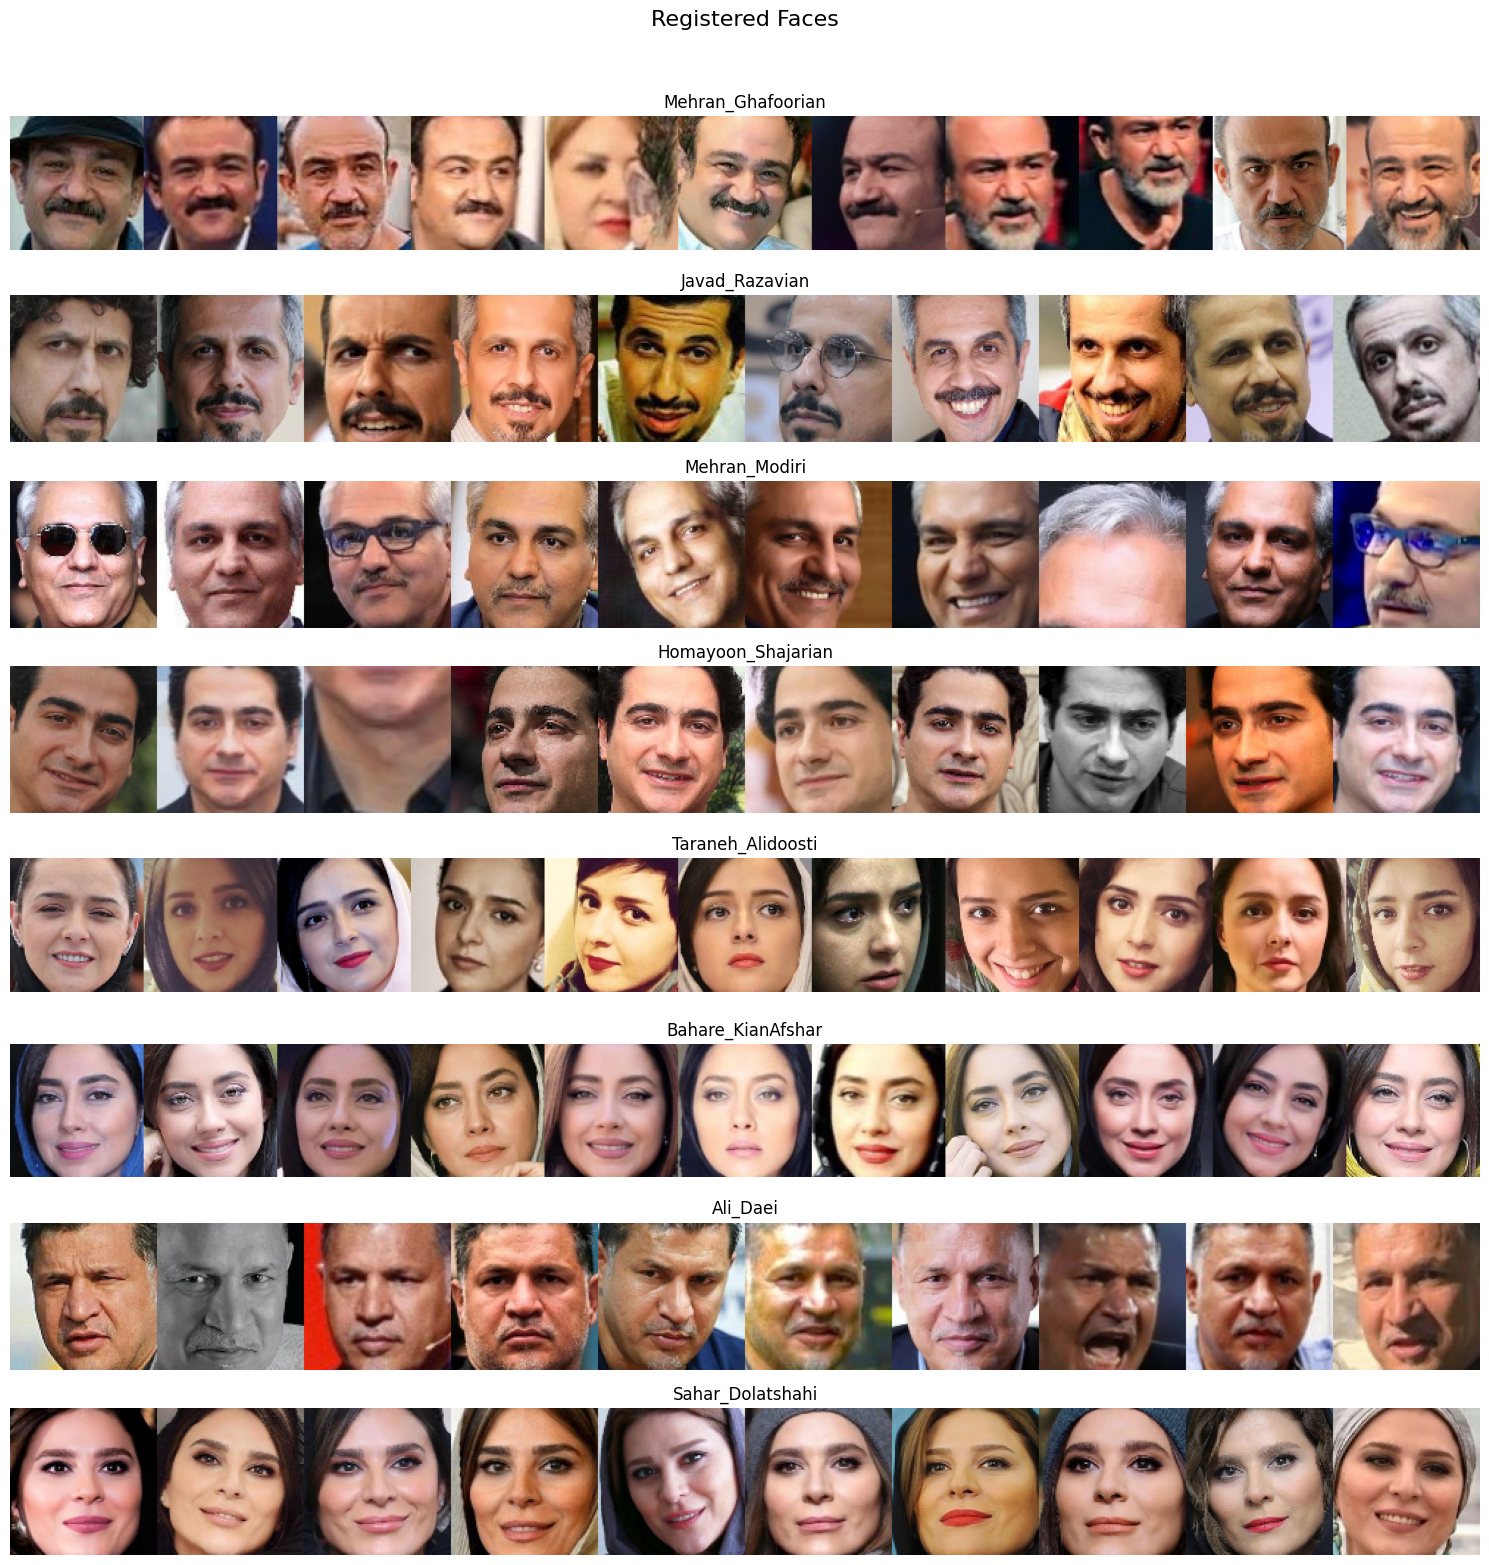

In [63]:
face_recog.view_database()

## Correct Predictions

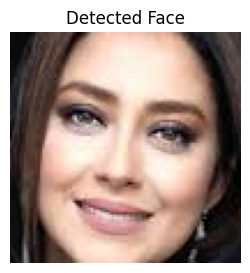

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Dissimilarity with all classes:
Mehran_Ghafoorian: 0.2942
Javad_Razavian: 0.2771
Mehran_Modiri: 0.2955
Homayoon_Shajarian: 0.2644
Taraneh_Alidoosti: 0.1817
Bahare_KianAfshar: 0.1236
Ali_Daei: 0.2985
Sahar_Dolatshahi: 0.1603
Recognized as Bahare_KianAfshar with avg dissimilarity 0.1236


In [67]:
print(face_recog.authenticate("b.jpg"))

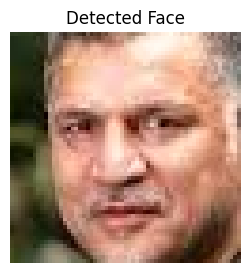

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
Dissimilarity with all classes:
Mehran_Ghafoorian: 0.2452
Javad_Razavian: 0.2773
Mehran_Modiri: 0.3014
Homayoon_Shajarian: 0.2856
Taraneh_Alidoosti: 0.3334
Bahare_KianAfshar: 0.3043
Ali_Daei: 0.2425
Sahar_Dolatshahi: 0.3236
Recognized as Ali_Daei with avg dissimilarity 0.2425


In [64]:
print(face_recog.authenticate("ad.jpg"))

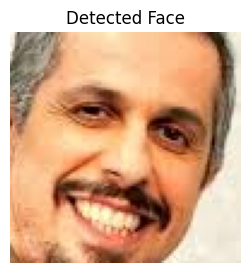

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
Dissimilarity with all classes:
Mehran_Ghafoorian: 0.2146
Javad_Razavian: 0.2053
Mehran_Modiri: 0.2411
Homayoon_Shajarian: 0.2402
Taraneh_Alidoosti: 0.2253
Bahare_KianAfshar: 0.2193
Ali_Daei: 0.2133
Sahar_Dolatshahi: 0.2301
Recognized as Javad_Razavian with avg dissimilarity 0.2053


In [65]:
print(face_recog.authenticate("img.png"))

## Wrong Predictions

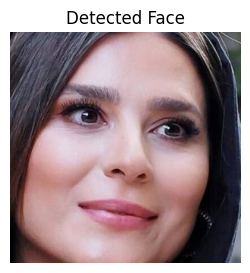

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
Dissimilarity with all classes:
Mehran_Ghafoorian: 0.3649
Javad_Razavian: 0.3021
Mehran_Modiri: 0.3237
Homayoon_Shajarian: 0.2753
Taraneh_Alidoosti: 0.1936
Bahare_KianAfshar: 0.1501
Ali_Daei: 0.3343
Sahar_Dolatshahi: 0.1580
Recognized as Bahare_KianAfshar with avg dissimilarity 0.1501


In [66]:
print(face_recog.authenticate("s3.jpg"))

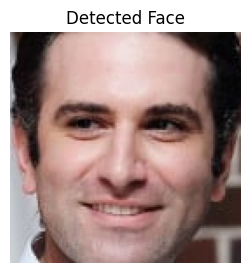

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
Dissimilarity with all classes:
Mehran_Ghafoorian: 0.2030
Javad_Razavian: 0.1963
Mehran_Modiri: 0.2265
Homayoon_Shajarian: 0.1808
Taraneh_Alidoosti: 0.2178
Bahare_KianAfshar: 0.2059
Ali_Daei: 0.1822
Sahar_Dolatshahi: 0.2157
Recognized as Homayoon_Shajarian with avg dissimilarity 0.1808


In [68]:
print(face_recog.authenticate("h2.jpg"))